# Background

<img src="img/LendingClubLogo.png" width="40%" align="left">

Lending Club is a peer to peer marketplace that connects borrowers of short term unsecured fixed installment loans with investors. Lending Club screens and underwrites the loans, divides them up into $25 notes, and lists them on their online marketplace for investors to purchase.

Investors can either filter loans manually, enroll in automatic investing, or use their API to implement their own investing strategy.

**With so options to filter loans by, how do we select the settings that minimize loan defaults and thereby optimize our returns?**

<img src='img/filters.png' width="20%" alighn="left" style="float: left">
<img src='img/more_options.png' width="75%" alighn="left">

# Objective

With the goal of transparency, Lending Club publishes anonymized loan data for all loans issued on their platform. Using that dataset, we want to build a model to predict whether a loan will default or not.

For this analysis, rather than using the offical data set, a simplified and smaller version of the dataset of from Kaggle is being used. This includes all the loans Lending Club issued from 2007 to 2015.

# Hypothesis

The most important predictors in determining whether a user will default or not are:
* **dti** => Debt to monthly income ratio
* **int_rate** => Fixed interest rate on loan
* **term** => Number of months. Longer terms are more likely to default.
* **delinq_2yrs** => The Number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years.
* **acc_now_delinq** => The Number of accounts on which the borrower is now delinquent.
* **annual_inc** => Annual income.

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
%matplotlib inline
pd.set_option('display.max_rows', 200)

In [2]:
def read_loan_data():
    """Read in data from 12 files and concatentate into one dataframe"""
    dataframes = []
    for i in range(12):
        filename = './data/loans-kaggle-%d.csv' % i
        df = pd.read_csv(filename, low_memory=False)
        dataframes.append(df)
    loans = pd.concat(dataframes)
    return loans

loans = read_loan_data()

In [3]:
loans.shape

(887379, 74)

In [4]:
loans.columns

Index([u'id', u'member_id', u'loan_amnt', u'funded_amnt', u'funded_amnt_inv',
       u'term', u'int_rate', u'installment', u'grade', u'sub_grade',
       u'emp_title', u'emp_length', u'home_ownership', u'annual_inc',
       u'verification_status', u'issue_d', u'loan_status', u'pymnt_plan',
       u'url', u'desc', u'purpose', u'title', u'zip_code', u'addr_state',
       u'dti', u'delinq_2yrs', u'earliest_cr_line', u'inq_last_6mths',
       u'mths_since_last_delinq', u'mths_since_last_record', u'open_acc',
       u'pub_rec', u'revol_bal', u'revol_util', u'total_acc',
       u'initial_list_status', u'out_prncp', u'out_prncp_inv', u'total_pymnt',
       u'total_pymnt_inv', u'total_rec_prncp', u'total_rec_int',
       u'total_rec_late_fee', u'recoveries', u'collection_recovery_fee',
       u'last_pymnt_d', u'last_pymnt_amnt', u'next_pymnt_d',
       u'last_credit_pull_d', u'collections_12_mths_ex_med',
       u'mths_since_last_major_derog', u'policy_code', u'application_type',
       u'annu

### We are trying to predict whether a loan will default or not. We normalize the target variable to 0 or 1 so it becomes a binary classification.

In [5]:
loans.loan_status.value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [6]:
loans['defaulted'] = loans.loan_status.map({'Fully Paid': 0,
                                            'Current': 0,
                                            'Charged Off': 1,
                                            'Late (31-120 days)': 1,
                                            'Issued': 0,
                                            'In Grace Period': 0,
                                            'Late (16-30 days)': 0,
                                            'Does not meet the credit policy. Status:Fully Paid': 0,
                                            'Does not meet the credit policy. Status:Charged Off': 1,
                                            'Default': 1
                                           })
loans.drop('loan_status', axis=1, inplace=True)

## Some Exploratory Data Analysis

### What kind of interest rate are borrowers paying?

/home/ubuntu/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


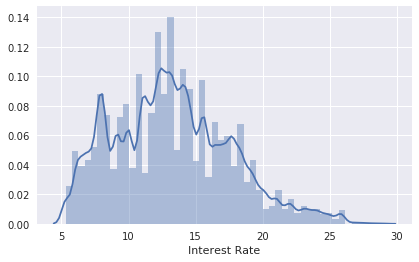

In [7]:
sns.distplot(loans.int_rate, axlabel='Interest Rate');

As expected, higher interest rates are more likely to default.

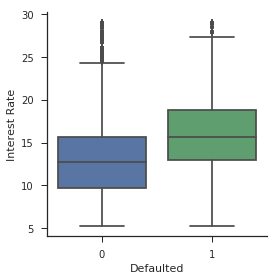

In [8]:
with sns.axes_style(style='ticks'):
    g = sns.factorplot("defaulted", "int_rate", data=loans, kind="box")
    g.set_axis_labels("Defaulted", "Interest Rate");

### How long are the loans terms?

In [9]:
loans.term.value_counts(1)

 36 months    0.699955
 60 months    0.300045
Name: term, dtype: float64

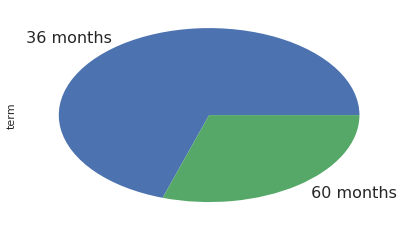

In [10]:
loans.term.value_counts().plot(kind='pie', fontsize=16);

Once again, as expected, longer term loans carry higher risk.

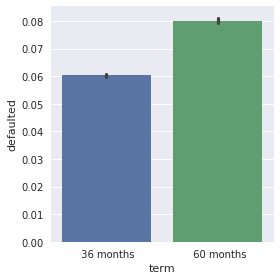

In [11]:
sns.factorplot(x='term', y='defaulted', kind='bar', data = loans);

### How much are people borrowing?

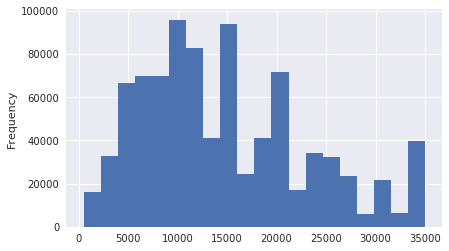

In [12]:
loans.loan_amnt.plot(kind='hist', bins=20, x='Loan Amount');

Seems like people like to round up to multiples of 5k such as 10k and 15k when applying.

Not much correlation between loan amount and defaults.

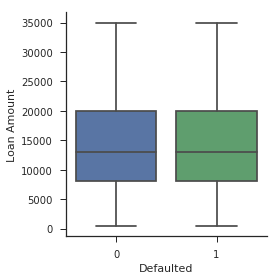

In [13]:
with sns.axes_style(style='ticks'):
    g = sns.factorplot("defaulted", "loan_amnt", data=loans, kind="box")
    g.set_axis_labels("Defaulted", "Loan Amount");

### What are people taking these loans out for?

In [14]:
purposes = loans.purpose.value_counts()
purposes

debt_consolidation    524215
credit_card           206182
home_improvement       51829
other                  42894
major_purchase         17277
small_business         10377
car                     8863
medical                 8540
moving                  5414
vacation                4736
house                   3707
wedding                 2347
renewable_energy         575
educational              423
Name: purpose, dtype: int64

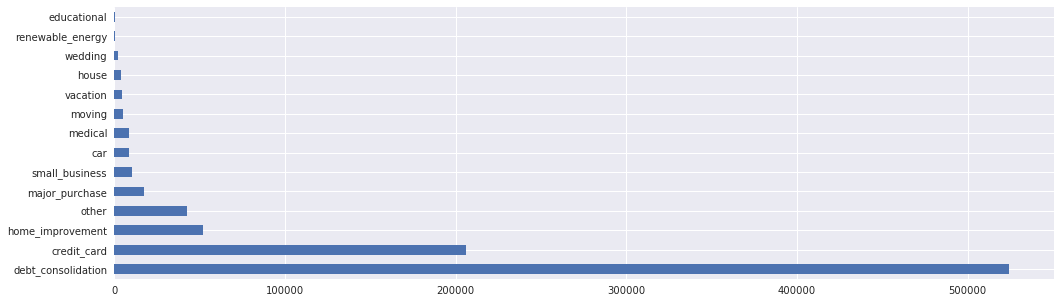

In [15]:
purposes.plot.barh(figsize=(15, 5));

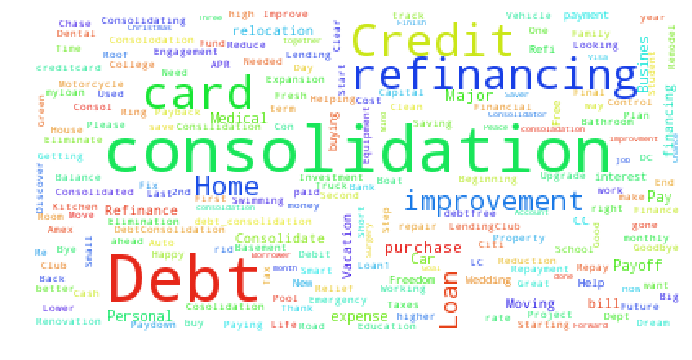

In [16]:
titles = loans.title.str.cat(sep=',')
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', max_font_size=40, relative_scaling=0.5)
wordcloud.generate(titles)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Unlike purpose, which is a drop down menu in the loan application, title is open text entered by the borrower

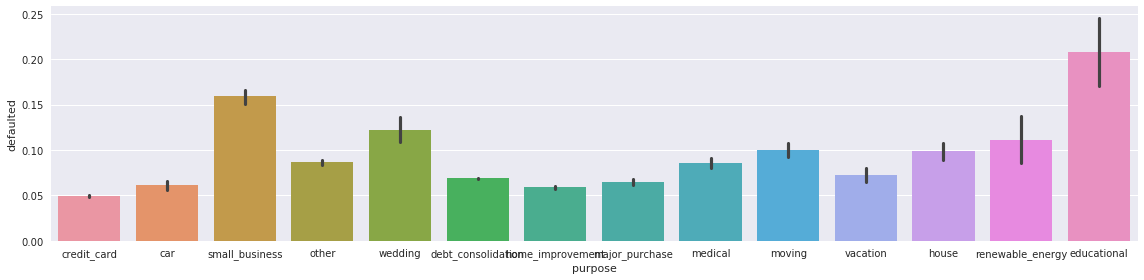

In [17]:
sns.factorplot(x='purpose', y='defaulted', kind='bar', data = loans, aspect=4);

It seems like borrowers who took out a loan for education, a small business, or wedding are more likely to default.

### How much do borrowers earn?

In [18]:
loans.verification_status.value_counts(1)

Source Verified    0.371384
Verified           0.328012
Not Verified       0.300604
Name: verification_status, dtype: float64

About 33% of borrowers had their income verified to within an acceptable range. Another 37% had the source of their income verified, potentially by calling their employer, but not their actual income. Finally, the remaining 30% were not verified at all. We'll remove outliers from all the loans where income was not verified.

In [19]:
median_annual_inc = loans.annual_inc.median()
ninety_ninth_percentile = loans.annual_inc.quantile(0.99)
loans.loc[(loans.verification_status != 'Verified') & (loans.annual_inc > ninety_ninth_percentile), 'annual_inc'] = \
    median_annual_inc

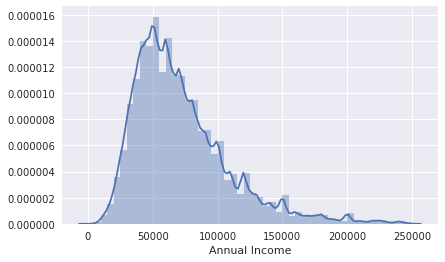

In [20]:
# Density plot of 99th percentile of annual income
annual_inc_99 = loans[loans.annual_inc.notnull() & (loans.annual_inc < loans.annual_inc.quantile(0.99))]
sns.distplot(annual_inc_99.annual_inc, axlabel='Annual Income');

Some correlation between annual income and defaults.

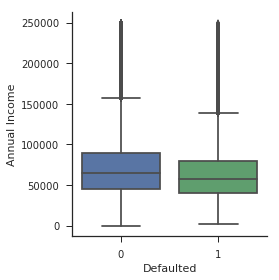

In [21]:
with sns.axes_style(style='ticks'):
    g = sns.factorplot("defaulted", "annual_inc", data=annual_inc_99, kind="box")
    g.set_axis_labels("Defaulted", "Annual Income");

### What about debt to income ratio?

Similar to annual income, normalize the 89 outliers to the median.

In [23]:
median_dti = loans.dti.median()
ninety_ninth_percentile = loans.dti.quantile(.9999)
loans.loc[loans.dti > ninety_ninth_percentile, 'dti'] = median_dti

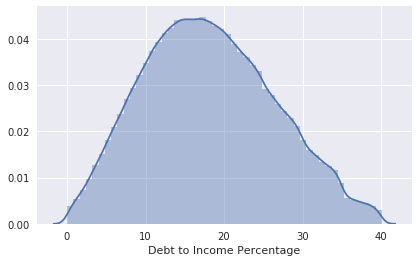

In [24]:
sns.distplot(loans.dti, axlabel='Debt to Income Percentage');

Not much of a correlation here.

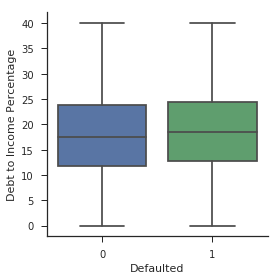

In [25]:
with sns.axes_style(style='ticks'):
    g = sns.factorplot("defaulted", "dti", data=loans, kind="box")
    g.set_axis_labels("Defaulted", "Debt to Income Percentage");

### Are the borrowers renters or home owners?

In [26]:
loans.home_ownership.value_counts(1)

MORTGAGE    0.499851
RENT        0.401313
OWN         0.098571
OTHER       0.000205
NONE        0.000056
ANY         0.000003
Name: home_ownership, dtype: float64

In [27]:
loans.loc[(loans.home_ownership == 'ANY') | (loans.home_ownership == 'NONE'), 'home_ownership'] = 'OTHER'

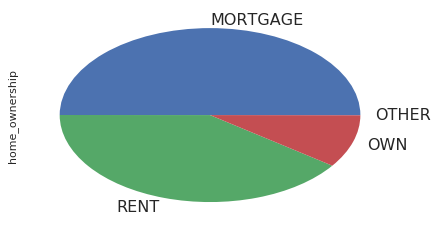

In [28]:
loans.home_ownership.value_counts().plot(kind='pie', fontsize=16);

Seems like renters do default more. Other is a really small percentage of all borrowers.

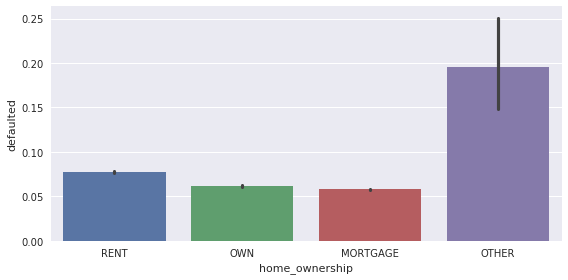

In [29]:
sns.factorplot(x='home_ownership', y='defaulted', kind='bar', data = loans, aspect=2);

### LendingClub rates their loans from A to G, with subgrades 1 to 5

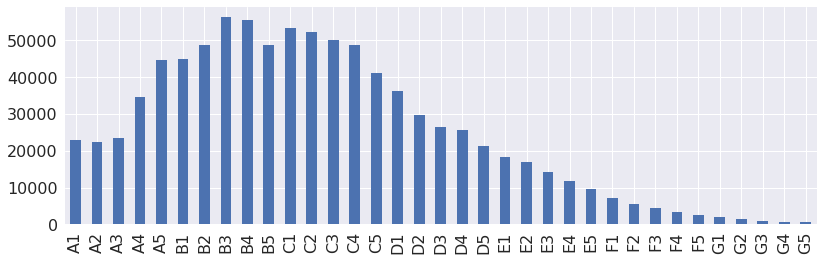

In [30]:
loans.sub_grade.value_counts().sort_index().plot(kind='bar', fontsize=16, figsize=(12, 4));

Seems like Lending Club does a decent job of grading their loans. Lower grade loans default more.

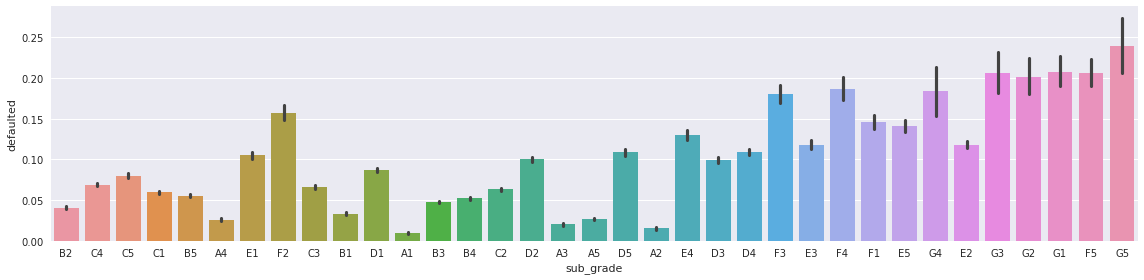

In [31]:
sns.factorplot(x='sub_grade', y='defaulted', kind='bar', data = loans, aspect=4);

### Is the number of delinquencies in the past 2 years relevant?

In [32]:
def bucketize_delinquencies(x):
    if x == 0:
        return '0'
    elif x > 0 and x <= 4:
        return '1 to 4'
    elif x > 4 and x <= 8:
        return '5 to 8'
    return '> 8'

loans['delinq_2yrs_range'] = loans.delinq_2yrs.apply(bucketize_delinquencies)

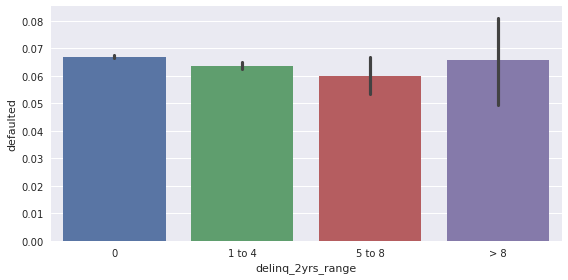

In [33]:
sns.factorplot(x='delinq_2yrs_range', y='defaulted', kind='bar', data = loans, aspect=2);

In [ ]:
loans.drop('delinq_2yrs_range', axis=1, inplace=True)

### What about accounts currently delinquent?

In [34]:
loans.acc_now_delinq.value_counts()

0.0     883236
1.0       3866
2.0        208
3.0         28
4.0          7
5.0          3
6.0          1
14.0         1
Name: acc_now_delinq, dtype: int64

In [35]:
def bucketize_current_delinquent(x):
    if x == 0:
        return '0'
    elif x == 1:
        return '1'
    return '> 1'
loans['acc_now_delinq_range'] = loans.acc_now_delinq.apply(bucketize_current_delinquent)

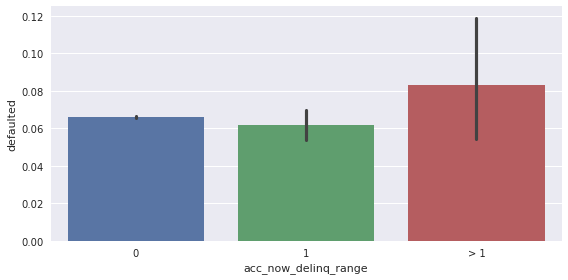

In [36]:
sns.factorplot(x='acc_now_delinq_range', y='defaulted', kind='bar', data = loans, aspect=2);

In [37]:
loans.drop('acc_now_delinq_range', axis=1, inplace=True)

# Lots of null values. Let's clean up the data.

In [38]:
null_value_count = loans.isnull().sum().sort_values(ascending=False)
null_value_count[null_value_count != 0]

dti_joint                      886870
annual_inc_joint               886868
verification_status_joint      886868
il_util                        868762
mths_since_rcnt_il             866569
open_acc_6m                    866007
open_il_12m                    866007
open_il_24m                    866007
total_bal_il                   866007
open_il_6m                     866007
open_rv_12m                    866007
open_rv_24m                    866007
max_bal_bc                     866007
all_util                       866007
inq_fi                         866007
total_cu_tl                    866007
inq_last_12m                   866007
desc                           761350
mths_since_last_record         750326
mths_since_last_major_derog    665676
mths_since_last_delinq         454312
next_pymnt_d                   252971
total_rev_hi_lim                70276
tot_cur_bal                     70276
tot_coll_amt                    70276
emp_title                       51457
last_pymnt_d

Joint applications were introduced late in 2015. For the vast majority of individual applications, set joint_dti to 0, annual_inc_joint to 0, and verification_status_joint to 'Not applicable'

In [39]:
loans[loans.application_type == 'JOINT'].issue_d.value_counts()

Dec-2015    250
Nov-2015    187
Oct-2015     74
Name: issue_d, dtype: int64

In [40]:
loans[(loans.application_type == 'JOINT') & loans.dti_joint.isnull() & loans.annual_inc_joint.isnull()
     & loans.verification_status_joint.isnull()].shape

(0, 75)

In [41]:
loans['dti_joint'].fillna(value=0.0, inplace=True)
loans['annual_inc_joint'].fillna(value=0.0, inplace=True)
loans['verification_status_joint'].fillna(value='Not Applicable', inplace=True)

These fields were added on December 2015 and only exist for new loans. We can just drop them.

In [42]:
dec_2015_columns = ['il_util', 'mths_since_rcnt_il', 'open_acc_6m', 'inq_last_12m', 'open_il_6m', 'open_il_12m',
                   'open_il_24m', 'total_bal_il', 'open_rv_12m', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',
                   'inq_fi', 'total_cu_tl', 'all_util']
loans = loans.drop(dec_2015_columns, axis=1)

Description is missing for most loans and since we are not doing any keyword or sentiment analyis, we can drop it.

In [66]:
loans.desc.isnull().sum()

761349

In [67]:
loans = loans.drop('desc', axis=1)

Public records are derogatory records such as bankruptcy, civil judgment, and tax liens. These values are missing because these loans have no negative public records. Let's set the value to a very high number, i.e., 360

In [43]:
loans[loans.mths_since_last_record.isnull() & (loans.pub_rec > 0)].shape

(0, 61)

In [44]:
loans.mths_since_last_record.fillna(value=360, inplace=True)

Derogatories are public records or loans which have been delinquent for more than 90 days. mths_since_last_major_derog is the number of months since the last derogatory record. Since it's missing for most loans, we set it to the max of the column.

In [45]:
loans['mths_since_last_major_derog'].fillna(value=loans.mths_since_last_major_derog.max(), inplace=True)

mths_since_last_delinq is the number of months since last delinquency. If they currently have a delinquent account or one in the past two years, we set it to 0. Otherwise set it to max of column.

In [46]:
max_months = loans.mths_since_last_delinq.max()
def impute_mths_since_last_delinq(row):  
    months = max_months
    if row.acc_now_delinq > 0 or row.delinq_2yrs > 0:
        months = 0
    return months

loans.loc[loans.mths_since_last_delinq.isnull(), 'mths_since_last_delinq'] = \
    loans[loans.mths_since_last_delinq.isnull()].apply(impute_mths_since_last_delinq, axis=1)

For the following, we will impute using the median:
* **tot_cur_bal** => Total current balance of all accounts
* **total_rev_hi_lim** => Total revolving credit limit
* **tot_coll_amt** => Total collection amounts ever owed
* **revol_util** => Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
* **collections_12_mths_ex_med** => Number of collections in 12 months excluding medical collections.

In [47]:
loans.tot_cur_bal.fillna(loans.tot_cur_bal.median(), inplace=True)
loans.total_rev_hi_lim.fillna(loans.total_rev_hi_lim.median(), inplace=True)
loans.tot_coll_amt.fillna(loans.tot_coll_amt.median(), inplace=True)
loans.revol_util.fillna(loans.revol_util.median(), inplace=True)
loans.collections_12_mths_ex_med.fillna(loans.collections_12_mths_ex_med.median(), inplace=True)

Since there are so many different employment titles, we cannot include it as a categorical feature. So we drop it.

In [48]:
loans.emp_title.value_counts().count()

299272

In [49]:
loans.drop('emp_title', axis=1, inplace=True)

These 29 loans issued in the summer of 2007 when Lending Club's screening process was still being implemented. We can simply remove these loans.

In [50]:
loans[loans.acc_now_delinq.isnull() & loans.total_acc.isnull() & loans.pub_rec.isnull() & loans.open_acc.isnull()
     & loans.inq_last_6mths.isnull() & loans.delinq_2yrs.isnull()].shape[0]

29

In [51]:
loans[loans.acc_now_delinq.isnull() & loans.total_acc.isnull() & loans.pub_rec.isnull() & loans.open_acc.isnull()
     & loans.inq_last_6mths.isnull() & loans.delinq_2yrs.isnull()].issue_d.value_counts()

Jun-2007    21
Aug-2007     4
Jul-2007     4
Name: issue_d, dtype: int64

In [52]:
missing_summer_2007 = ['delinq_2yrs', 'acc_now_delinq', 'inq_last_6mths', 'open_acc', 'pub_rec', 'total_acc']
loans.dropna(subset=missing_summer_2007, inplace=True)

Loans ID, Member ID and URL are unique to each loan, so we can drop those columns

In [53]:
loans.drop(['id', 'member_id', 'url'], axis=1, inplace=True)

We can drop title since we already have purpose as a categorical feature.

In [54]:
loans.drop('title', axis=1, inplace=True)

Drop all the columns that are dates.

In [55]:
date_columns = ['last_pymnt_d', 'earliest_cr_line', 'next_pymnt_d', 'last_credit_pull_d', 'issue_d']
loans.drop(date_columns, axis=1, inplace=True)

Employment length is ordinal. We convert it integers 0 to 10. For n/a, we assume that if the user left it blank, they are self employed or have other sources of income. So we map it 0.

In [56]:
loans.emp_length.value_counts()

10+ years    291566
2 years       78869
< 1 year      70587
3 years       70024
1 year        57092
5 years       55704
4 years       52529
n/a           44825
7 years       44594
8 years       43955
6 years       42949
9 years       34656
Name: emp_length, dtype: int64

In [57]:
def fix_employment_length(x):
    years = 0
    if x == 'n/a' or x[:1] == '<':
        years = 0
    elif x[:3] == '10+':
        years = 10
    else:
        years = int(x[:1])
    return years

loans['emp_length'] = loans.emp_length.apply(fix_employment_length)

We'll drop zip code, but keep state as a categorical feature

In [58]:
loans.drop('zip_code', axis=1, inplace=True)

Lending Club generally sells fractional notes of whole loans. But they also sell whole loans to institutional investors who request it. initial_list_status captures that as 'w' or 'f'. Since, it's not relevant to the borrower, we drop it.

In [59]:
loans.drop('initial_list_status', axis=1, inplace=True)

Policy code is 1 for all the loans in this dataset, so we can drop it.

In [60]:
loans.drop('policy_code', axis=1, inplace=True)

We remove the following because they aren't relevant or available through API as when loan is listed.
* **recoveries** => Post charge off gross recovery
* **collection_recovery_fee** => Post charge off collection fee
* **out_prncp** => Remaining outstanding principal for total amount funded
* **out_prncp_inv** => Remaining outstanding principal for portion of total amount funded by investors
* **total_rec_prncp** => Principal received to date
* **last_pymnt_amnt** => Last total payment amount received
* **total_pymnt** => Payments received to date for total amount funded
* **total_pymnt_inv** => Payments received to date for portion of total amount funded by investors
* **total_rec_late_fee** => Late fees received to date
* **funded_amnt** => The total amount committed to that loan at that point in time
* **funded_amnt_inv** => The total amount committed by investors for that loan at that point in time
* **total_rec_int** => Interest received to date

In [61]:
columns_to_drop = ['recoveries', 'collection_recovery_fee', 'out_prncp', 'out_prncp_inv', 'total_rec_prncp',
                   'last_pymnt_amnt', 'total_pymnt', 'total_pymnt_inv', 'total_rec_late_fee', 'funded_amnt',
                   'funded_amnt_inv', 'total_rec_int']
loans.drop(columns_to_drop, axis=1, inplace=True)

### Create dummy variables for the categorical features

In [62]:
loans.shape

(887350, 36)

In [63]:
categorical_features = ['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'pymnt_plan',
                        'purpose', 'addr_state', 'application_type', 'verification_status_joint']
loans = pd.get_dummies(loans, columns=categorical_features)

In [64]:
loans.shape

(887350, 150)

# Split the data into train and test

In [65]:
X = loans.drop('defaulted', axis=1)
y = loans['defaulted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now let's build a Random Forest Classifier

In [ ]:
param_grid = {class_weight': ['balanced', None], 'max_depth': np.arange(1, 10)}
# max_features is another param
# NOTE: Out of bag error

cv = StratifiedKFold(5, shuffle=True, random_state=42)
clf_rf = GridSearchCV(RandomForestClassifier(n_estimators=100), param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2)
clf_rf.fit(X_train, y_train)

In [ ]:
clf_rf.best_estimator_

In [ ]:
clf_rf.best_score_

In [ ]:
feature_importances = list(zip(list(X.columns), clf_rf.best_estimator_.feature_importances_))
feature_importances.sort(lambda x, y: cmp(x[1], y[1]), reverse=True)
feature_importances[:25]

In [ ]:
y_pred_class = clf_rf.best_estimator_.predict(X_test)

In [ ]:
y_pred_prob = clf_rf.best_estimator_.predict_proba(X_test)[:, 1]

In [ ]:
print metrics.accuracy_score(y_test, y_pred_class)

In [ ]:
print metrics.roc_auc_score(y_test, y_pred_prob)

In [ ]:
# plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')